In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
os.chdir("D:\\mywork\\lincGNN\\cal")


D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
edges_df = pd.read_csv('Net_final.csv', index_col=0)
print(edges_df)

       Regulator       Target RegulatorType TargetType regulatory_Mechanism
1          NEAT1   miR-194-5p        lncRNA      miRNA      ceRNA or sponge
2      LINC00460      miR-206        lncRNA      miRNA      ceRNA or sponge
3         MALAT1      miR-497        lncRNA      miRNA      ceRNA or sponge
4           MIAT      miR-29b        lncRNA      miRNA      ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p        lncRNA      miRNA      ceRNA or sponge
...          ...          ...           ...        ...                  ...
9513       WWTR1         YAP1           PCG        PCG            interacts
9514        YAP1        YWHAH           PCG        PCG            interacts
9515        YAP1        YWHAZ           PCG        PCG            interacts
9516        YAP1         YES1           PCG        PCG            interacts
9517       YWHAH        YWHAZ           PCG        PCG            interacts

[9517 rows x 5 columns]


In [3]:
all_nodes = pd.concat([edges_df['Regulator'], edges_df['Target']]).unique()
node2id = {node: idx for idx, node in enumerate(all_nodes)}
id2type = {}
for _, row in edges_df.iterrows():
    id2type[node2id[row['Regulator']]] = row['RegulatorType']
    id2type[node2id[row['Target']]] = row['TargetType']

edge_index = torch.tensor([
    [node2id[r] for r in edges_df['Regulator']],
    [node2id[t] for t in edges_df['Target']]
], dtype=torch.long)
data = Data(edge_index=edge_index, num_nodes=len(all_nodes))
print(data)

Data(edge_index=[2, 9517], num_nodes=2598)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1, q=1, sparse=True
).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 51):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

model.eval()

Epoch 1, Loss: 5.5626
Epoch 2, Loss: 4.6303
Epoch 3, Loss: 3.9107
Epoch 4, Loss: 3.2744
Epoch 5, Loss: 2.7521
Epoch 6, Loss: 2.3276
Epoch 7, Loss: 1.9899
Epoch 8, Loss: 1.7209
Epoch 9, Loss: 1.5056
Epoch 10, Loss: 1.3365
Epoch 11, Loss: 1.2003
Epoch 12, Loss: 1.0970
Epoch 13, Loss: 1.0157
Epoch 14, Loss: 0.9525
Epoch 15, Loss: 0.9063
Epoch 16, Loss: 0.8689
Epoch 17, Loss: 0.8425
Epoch 18, Loss: 0.8215
Epoch 19, Loss: 0.8055
Epoch 20, Loss: 0.7940
Epoch 21, Loss: 0.7842
Epoch 22, Loss: 0.7755
Epoch 23, Loss: 0.7684
Epoch 24, Loss: 0.7638
Epoch 25, Loss: 0.7589
Epoch 26, Loss: 0.7552
Epoch 27, Loss: 0.7518
Epoch 28, Loss: 0.7481
Epoch 29, Loss: 0.7459
Epoch 30, Loss: 0.7440
Epoch 31, Loss: 0.7415
Epoch 32, Loss: 0.7404
Epoch 33, Loss: 0.7388
Epoch 34, Loss: 0.7370
Epoch 35, Loss: 0.7362
Epoch 36, Loss: 0.7351
Epoch 37, Loss: 0.7341
Epoch 38, Loss: 0.7330
Epoch 39, Loss: 0.7321
Epoch 40, Loss: 0.7315
Epoch 41, Loss: 0.7309
Epoch 42, Loss: 0.7300
Epoch 43, Loss: 0.7293
Epoch 44, Loss: 0.72

Node2Vec(2598, 128)

In [5]:
z = model(torch.arange(data.num_nodes, device=device))

id2node = {v: k for k, v in node2id.items()}
all_node_names = [id2node[i] for i in range(data.num_nodes)]
all_node_types = [id2type[i] for i in range(data.num_nodes)]

all_emb_df = pd.DataFrame(z.cpu().detach().numpy(), index=all_node_names)
all_emb_df['NodeType'] = all_node_types
all_emb_df.index.name = 'Node'
print(all_emb_df)

                   0         1         2         3         4         5  \
Node                                                                     
NEAT1      -0.055863 -0.003457  0.064911  0.041244  0.041424  0.093168   
LINC00460  -0.253676 -0.057549 -0.022377 -0.095660  0.086581  0.072724   
MALAT1     -0.011251  0.017768  0.045886 -0.065337  0.048537  0.087898   
MIAT       -0.207139 -0.005161  0.069297 -0.044643 -0.022088 -0.031525   
CDKN2B-AS1  0.050059 -0.020030 -0.056061 -0.060639  0.008322 -0.032604   
...              ...       ...       ...       ...       ...       ...   
SET        -0.247483 -0.298025 -0.403757 -0.074024  0.087535  0.122108   
RAD54B      0.169087 -0.245024  0.019864  0.392142  0.134617 -0.461864   
SLIT2       0.044283 -0.087084  0.578255  0.316818 -0.159734 -0.354278   
TACR1      -0.105023 -0.081961 -0.039937 -0.039996  0.301216 -0.041136   
TUBB3       0.421463 -0.080547  0.205501  0.085126 -0.234217 -0.108316   

                   6         7       

In [6]:
lncrna_mask = [nid for nid, t in id2type.items() if t == 'lncRNA']
lncrna_names = [id2node[nid] for nid in lncrna_mask]
lncrna_emb = z[lncrna_mask].cpu().detach().numpy()
lncrna_emb_df = pd.DataFrame(lncrna_emb, index=lncrna_names,
                             columns=[f'feature_{i+1}' for i in range(lncrna_emb.shape[1])])
lncrna_emb_df.index.name = 'lncRNA'
lncrna_emb_df.to_csv('lncRNA_emb_features.csv')
print(lncrna_emb_df)

            feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
lncRNA                                                                         
NEAT1       -0.055863  -0.003457   0.064911   0.041244   0.041424   0.093168   
LINC00460   -0.253676  -0.057549  -0.022377  -0.095660   0.086581   0.072724   
MALAT1      -0.011251   0.017768   0.045886  -0.065337   0.048537   0.087898   
MIAT        -0.207139  -0.005161   0.069297  -0.044643  -0.022088  -0.031525   
CDKN2B-AS1   0.050059  -0.020030  -0.056061  -0.060639   0.008322  -0.032604   
...               ...        ...        ...        ...        ...        ...   
ARAP1-AS2    0.019993   0.086460  -0.140651   0.064933   0.013832  -0.053346   
TLR8-AS1    -0.006532   0.025442  -0.046530   0.074687  -0.164614  -0.128489   
GAS1RR      -0.079818   0.068059  -0.037492  -0.017668   0.043609   0.042931   
LINC01305    0.355733  -0.192571  -0.664036  -0.326366  -0.077434  -0.119115   
LINC00554   -0.022340   0.058084  -0.018

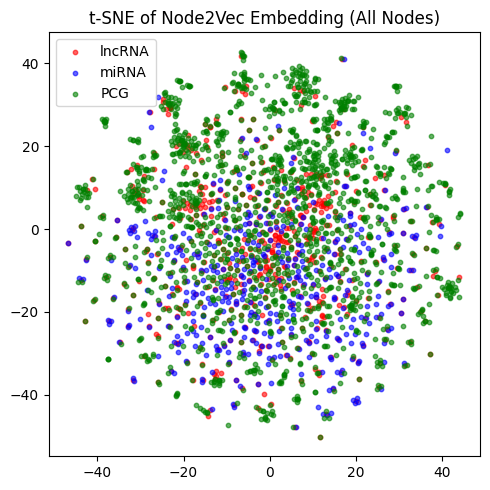

In [7]:
X = all_emb_df.iloc[:, :-1].values
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(5, 5))
type_colors = {'lncRNA': 'red', 'miRNA': 'blue', 'PCG': 'green'}
for t, color in type_colors.items():
    mask = (all_emb_df['NodeType'] == t)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=t, c=color, s=10, alpha=0.6)
plt.title('t-SNE of Node2Vec Embedding (All Nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("tsne_node2vec.pdf")   
plt.show()

In [11]:
lncrna_cluster_features_df = cluster_features_df.loc[all_emb_df['NodeType'] == 'lncRNA']
print(lncrna_cluster_features_df)
lncrna_cluster_features_df.to_csv('lncRNA_cluster_features.csv')

            cluster_k2  cluster_k3  cluster_k4  cluster_k5  cluster_k6  \
Node                                                                     
NEAT1                0           2           3           3           4   
LINC00460            0           2           3           3           4   
MALAT1               0           2           1           2           4   
MIAT                 0           2           1           2           4   
CDKN2B-AS1           0           2           1           2           1   
...                ...         ...         ...         ...         ...   
ARAP1-AS2            0           2           1           2           4   
TLR8-AS1             0           2           1           2           4   
GAS1RR               0           2           1           2           4   
LINC01305            0           2           1           2           4   
LINC00554            0           2           1           2           4   

            cluster_k7  cluster_k8  c

D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows wit

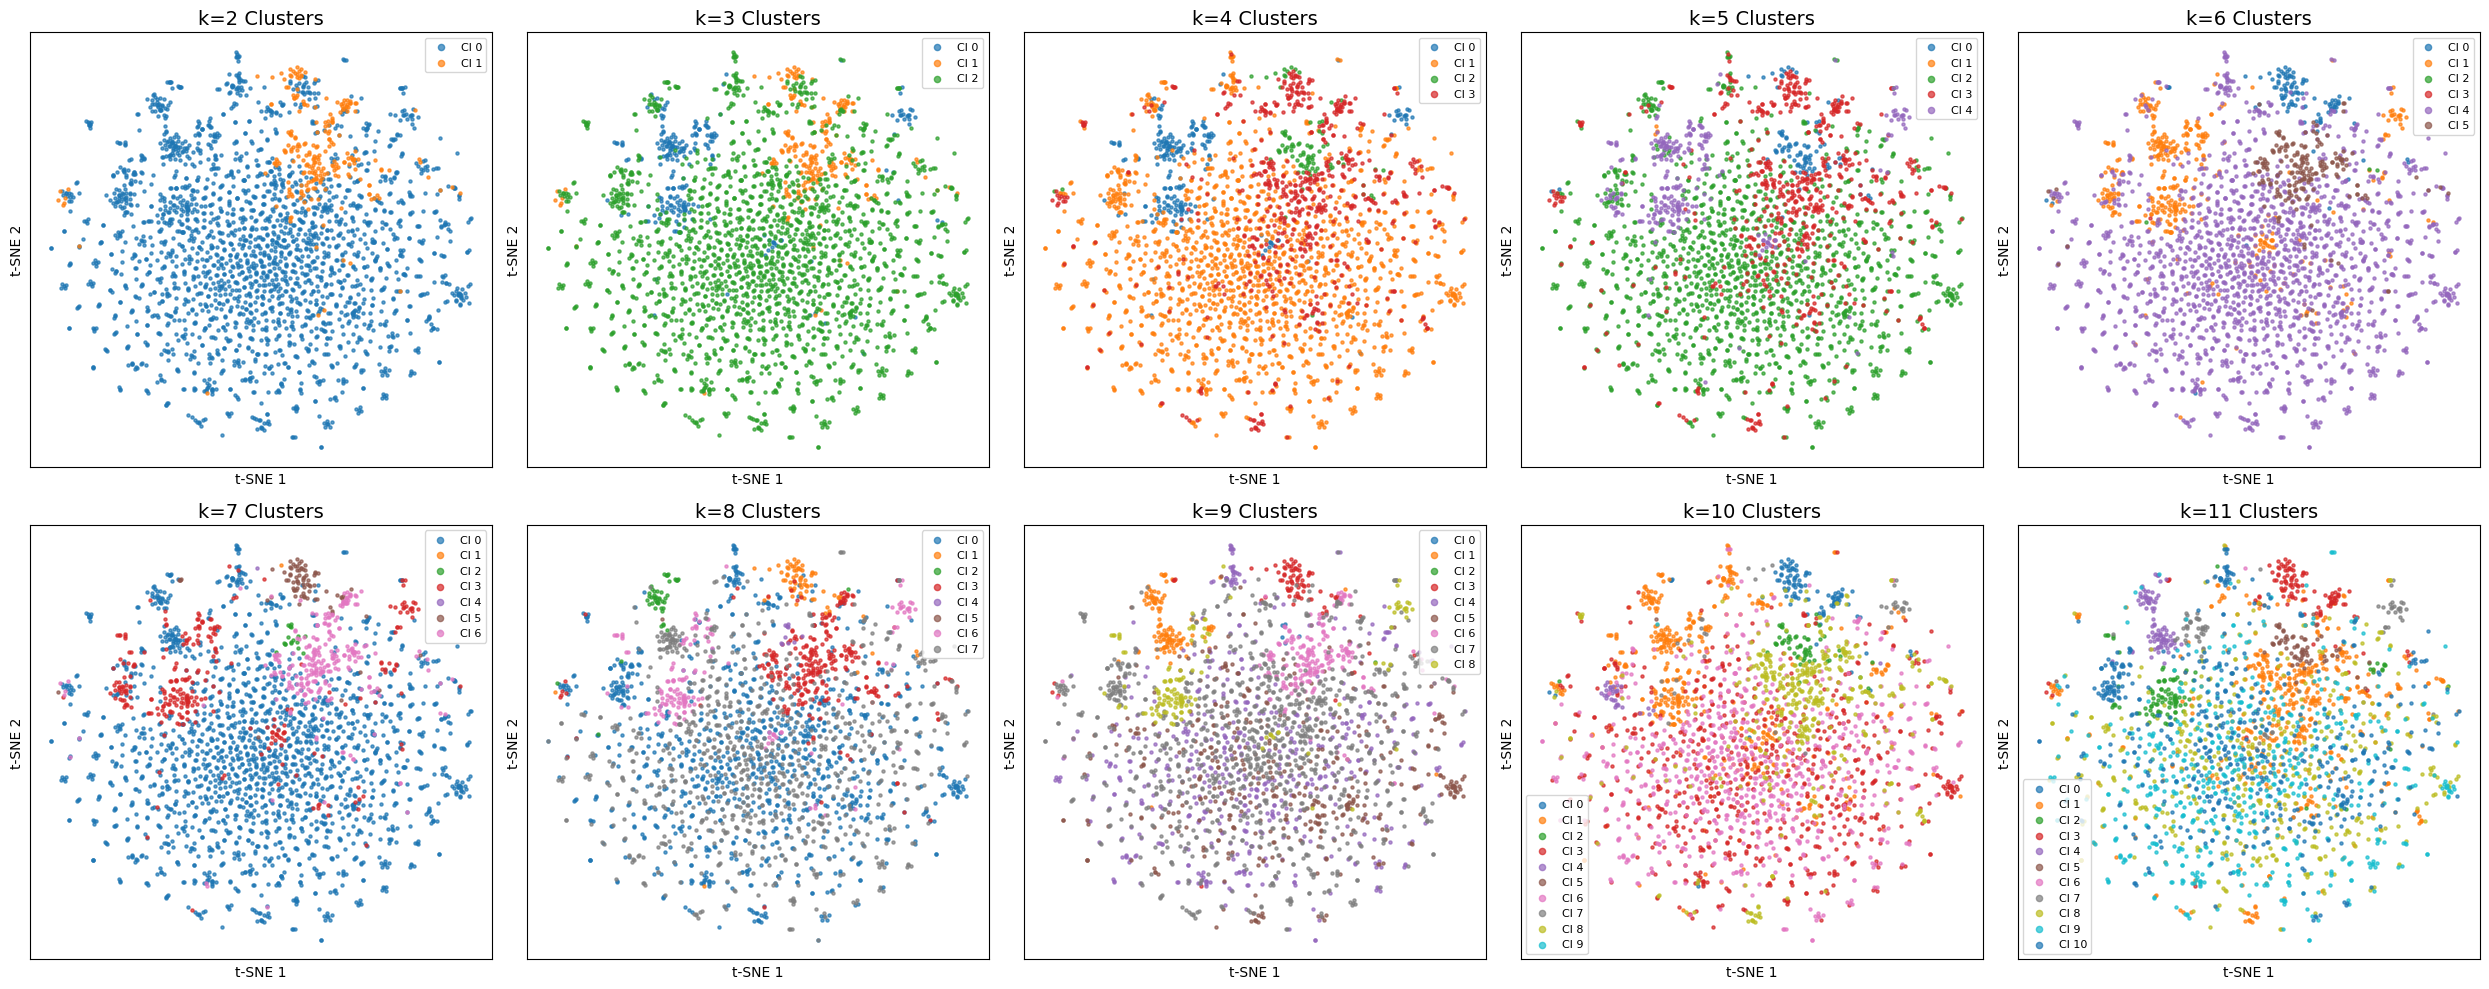

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for idx, k in enumerate(range(2, 12)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(X)
    cluster_features_df[f'cluster_k{k}'] = clusters

    ax = axes[idx]
    for cluster_id in range(k):
        mask = clusters == cluster_id
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   s=5, alpha=0.7, label=f'Cl {cluster_id}')
    ax.set_title(f'k={k} Clusters', fontsize=14)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(markerscale=2, loc='best', fontsize=8)

plt.tight_layout()
plt.savefig("kmeans_clusters_tsne.pdf", bbox_inches="tight")  
plt.show()
